# COVID-19 in Mexico

## Define the problem
COVID-19 is taking a big toll on the Mexican population. Currently having the 6th place worldwide. I decided to dive in and understand better the current situation in there.

The main question is: 
* Which factor has the biggest impact on deaths once infected with COVID-19?

Other questions to tackle are:
* Is there a correlation between cases and death with days of the week?
* Does the probability of death is increased by the number of days between first symptoms and hospitalization?

In [1]:
__author__ = "Erika Garces"
__email__ = "epgarces3@gmail.com"

In [2]:
# impory libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from os import listdir
import geopandas as gpd
import datetime as dt
from datetime import date

from sklearn import preprocessing

sns.set_style("ticks")
%matplotlib inline

## About datasets

COVID-19 data was taken from Ministry of Health MX:  https://www.gob.mx/salud/documentos/datos-abiertos-152127

Mexico's Shape File was taken from ESRI: https://www.arcgis.com/home/item.html?id=ac9041c51b5c49c683fbfec61dc03ba8

Population data was taken from INEGI and PopulationPyramid.net: 
* https://www.inegi.org.mx/temas/estructura/
* https://www.populationpyramid.net/es/méxico/2020/

## Load the Data 

In [3]:
# Function to print all the files in a folder 
def file_folder (path):
    filepaths = [path + f for f in listdir(path)]
    print (filepaths)

In [4]:
path = "Data/"
covid_general = file_folder(path)

['Data/datos_abiertos_20200810.csv', 'Data/datos_abiertos_20200811.csv', 'Data/gender.csv', 'Data/.DS_Store', 'Data/Mexico-2020.csv', 'Data/mexstates.dbf', 'Data/Catalogos_0412.xlsx', 'Data/mexstates.shp', 'Data/mexstates.shx', 'Data/mexstates.sbx', 'Data/Poblacion_Edad.xlsx', 'Data/.keep', 'Data/200802COVID19MEXICO.csv', 'Data/clean_data.csv', 'Data/01_poblacion.xls', 'Data/.ipynb_checkpoints', 'Data/mexstates.prj', 'Data/mexstates.sbn', 'Data/mexstates.shp.xml', 'Data/Poblacion_Entidad.xlsx', 'Data/Descriptores_0419.xlsx']


In [5]:
# Loading shape file
geo_states = gpd.read_file(path + "mexstates.shp")

In [6]:
# Loading covid-19 file 
df_genera_mx = pd.read_csv(path +"datos_abiertos_20200811.csv", encoding='latin-1')
df_general = df_genera_mx

In [7]:
#Population data
df_population = pd.read_excel(open(path + 'Poblacion_Entidad.xlsx', 'rb')) 
df_population.head()

,Num,Entidad,Total,Hombres,Mujeres
0,0.0,Estados Unidos Mexicanos,112336538.0,54855231.0,57481307.0
1,1.0,Aguascalientes,1184996.0,576638.0,608358.0
2,2.0,Baja California,3155070.0,1591610.0,1563460.0
3,3.0,Baja California Sur,637026.0,325433.0,311593.0
4,4.0,Campeche,822441.0,407721.0,414720.0


In [8]:
df_gender_pop = pd.read_csv(path + 'Mexico-2020.csv') 
df_gender_pop.head()

,Edad,M,F,Total
0,0-4,5604781,5353961,10958742
1,5-9,5731706,5478805,11210511
2,10-14,5692822,5448048,11140870
3,15-19,5695013,5514580,11209593
4,20-24,5505161,5434658,10939819


In [9]:
#COVID-19 file uses descriptors. The descriptors are analyzed below. 
df_descriptors = pd.read_excel(open(path + 'Descriptores_0419.xlsx', 'rb')) 
df_descriptors.head()

,Nº,NOMBRE DE VARIABLE,DESCRIPCIÓN DE VARIABLE,FORMATO O FUENTE
0,1,FECHA_ACTUALIZACION,"La base de datos se alimenta diariamente, esta...",AAAA-MM-DD
1,2,ID_REGISTRO,Número identificador del caso,TEXTO
2,3,ORIGEN,La vigilancia centinela se realiza a través de...,CATÁLOGO: ORIGEN ...
3,4,SECTOR,Identifica el tipo de institución del Sistema ...,CATÁLOGO: SECTOR ...
4,5,ENTIDAD_UM,Identifica la entidad donde se ubica la unidad...,CATALÓGO: ENTIDADES


In [10]:
df_states = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo de ENTIDADES') 
df_states.head()

,CLAVE_ENTIDAD,ENTIDAD_FEDERATIVA,ABREVIATURA
0,1,AGUASCALIENTES,AS
1,2,BAJA CALIFORNIA,BC
2,3,BAJA CALIFORNIA SUR,BS
3,4,CAMPECHE,CC
4,5,COAHUILA DE ZARAGOZA,CL


In [11]:
df_sector = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SECTOR') 
df_sector.head()

,CLAVE,DESCRIPCIÓN
0,1,CRUZ ROJA
1,2,DIF
2,3,ESTATAL
3,4,IMSS
4,5,IMSS-BIENESTAR


In [12]:
df_paciente = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo TIPO_PACIENTE') 
df_paciente

,CLAVE,DESCRIPCIÓN
0,1,AMBULATORIO
1,2,HOSPITALIZADO
2,99,NO ESPECIFICADO


In [13]:
df_gender = pd.read_excel(open(path + 'Catalogos_0412.xlsx', 'rb'), sheet_name='Catálogo SEXO') 
df_gender

,CLAVE,DESCRIPCIÓN
0,1,MUJER
1,2,HOMBRE
2,99,NO ESPECIFICADO


## Examine data

In [14]:
# checking the size of the file 
df_general.shape 

(1112114, 35)

In [15]:
# checking the data type of the columns
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112114 entries, 0 to 1112113
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   FECHA_ACTUALIZACION  1112114 non-null  object
 1   ID_REGISTRO          1112114 non-null  object
 2   ORIGEN               1112114 non-null  int64 
 3   SECTOR               1112114 non-null  int64 
 4   ENTIDAD_UM           1112114 non-null  int64 
 5   SEXO                 1112114 non-null  int64 
 6   ENTIDAD_NAC          1112114 non-null  int64 
 7   ENTIDAD_RES          1112114 non-null  int64 
 8   MUNICIPIO_RES        1112114 non-null  int64 
 9   TIPO_PACIENTE        1112114 non-null  int64 
 10  FECHA_INGRESO        1112114 non-null  object
 11  FECHA_SINTOMAS       1112114 non-null  object
 12  FECHA_DEF            1112114 non-null  object
 13  INTUBADO             1112114 non-null  int64 
 14  NEUMONIA             1112114 non-null  int64 
 15  EDAD           

In [16]:
#checking the first 5 rows.
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2020-08-11,1a62a3,2,3,15,1,15,15,2,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
1,2020-08-11,1491cc,2,3,27,1,27,27,4,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
2,2020-08-11,12bed1,2,3,15,1,15,15,106,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
3,2020-08-11,117245,2,3,25,2,26,25,6,1,...,2,2,2,2,99,1,99,MÃ©xico,99,97
4,2020-08-11,117cf6,2,3,27,1,27,27,13,2,...,2,2,2,2,2,1,99,MÃ©xico,99,2


In [17]:
df_general.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,UCI
count,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,...,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06,1.112114e+06
mean,1.660694e+00,9.257758e+00,1.574044e+01,1.497479e+00,1.653893e+01,1.597172e+01,3.816624e+01,1.188981e+00,7.904396e+01,1.865425e+00,...,2.096339e+00,2.370999e+00,2.232737e+00,2.087576e+00,2.230151e+00,2.185592e+00,2.991598e+01,1.630197e+00,9.862708e+01,7.904523e+01
std,4.734740e-01,3.650310e+00,8.169301e+00,4.999939e-01,9.914309e+00,8.085264e+00,4.887811e+01,3.914934e-01,3.721567e+01,5.116401e-01,...,5.003087e+00,6.163730e+00,4.924946e+00,4.883019e+00,4.880071e+00,5.064909e+00,4.435910e+01,6.157787e-01,6.011750e+00,3.721315e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,4.000000e+00,9.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,9.900000e+01,9.700000e+01
50%,2.000000e+00,1.200000e+01,1.500000e+01,1.000000e+00,1.500000e+01,1.500000e+01,2.100000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,9.700000e+01
75%,2.000000e+00,1.200000e+01,2.300000e+01,2.000000e+00,2.400000e+01,2.300000e+01,4.800000e+01,1.000000e+00,9.700000e+01,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,9.900000e+01,2.000000e+00,9.900000e+01,9.700000e+01
max,2.000000e+00,9.900000e+01,3.200000e+01,2.000000e+00,9.900000e+01,3.200000e+01,9.990000e+02,2.000000e+00,9.900000e+01,9.900000e+01,...,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.800000e+01,9.900000e+01,3.000000e+00,9.900000e+01,9.900000e+01


In [18]:
columns_ = df_general.columns
print(columns_)

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')


In [19]:
def value_counter(df, columns):
    for col in columns:
        result = df[col].value_counts()
        print (result) 

In [20]:

columns_remove = ('SECTOR','ORIGEN','FECHA_ACTUALIZACION', 'ID_REGISTRO','ENTIDAD_UM', 'EDAD',
                  'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','FECHA_INGRESO', 
                  'FECHA_SINTOMAS', 'FECHA_DEF','PAIS_NACIONALIDAD', 'MIGRANTE', 'PAIS_ORIGEN')
columns_review = [col for col in columns_ if col not in columns_remove]

In [21]:
value_counter(df_general, columns_review)

1    558861
2    553253
Name: SEXO, dtype: int64
1    901946
2    210168
Name: TIPO_PACIENTE, dtype: int64
97    901946
2     191780
1      18233
99       155
Name: INTUBADO, dtype: int64
2     960785
1     151312
99        17
Name: NEUMONIA, dtype: int64
1    1106750
2       5364
Name: NACIONALIDAD, dtype: int64
97    553253
2     546712
1       8467
98      3682
Name: EMBARAZO, dtype: int64
2     1064359
99      37937
1        9818
Name: HABLA_LENGUA_INDIG, dtype: int64
2     970397
1     138465
98      3252
Name: DIABETES, dtype: int64
2     1093646
1       15628
98       2840
Name: EPOC, dtype: int64
2     1076641
1       32635
98       2838
Name: ASMA, dtype: int64
2     1094156
1       14834
98       3124
Name: INMUSUPR, dtype: int64
2     928060
1     181052
98      3002
Name: HIPERTENSION, dtype: int64
2     1078701
1       28815
98       4598
Name: OTRA_COM, dtype: int64
2     1086637
1       22546
98       2931
Name: CARDIOVASCULAR, dtype: int64
2     932186
1     177069
98  

## Pre-processing data

In [22]:
df_population = df_population.dropna(how='all')
df_population['Num'] = df_population['Num'].astype(int)

In [23]:
df_general['ENTIDAD'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])
df_general['ENTIDAD_NAME'] = df_general['ENTIDAD_UM'].map(df_states.set_index('CLAVE_ENTIDAD')['ENTIDAD_FEDERATIVA'])
df_general['SECTOR'] = df_general['SECTOR'].map(df_sector.set_index('CLAVE')['DESCRIPCIÓN'])

In [24]:
df_general['TIPO_PACIENTE'] = df_general['TIPO_PACIENTE'].map(df_paciente.set_index('CLAVE')['DESCRIPCIÓN'])
df_general['SEXO']= df_general['SEXO'].replace([1, 2], ['Women', 'Men'])


In [25]:
# It replace values for several columns in a dataframe.
def replace_values(df, columns, 
                   old_values, new_values):
    for col in columns:
        try:
            df[col]= df[col].replace(to_replace=old_values, value=new_values)
        except:
            print(col)
    return df 

In [26]:
# It cast values for several columns in a dataframe.
def cast_values(df, columns, cast_value):
    for col in columns:
        try:
            df[col]= df[col].astype(cast_value)
        except:
            print(col)
    return df 

The columns below are dropped. 

In [27]:
df_general = df_general.drop(['ENTIDAD_NAC', 'ENTIDAD_RES', 'NACIONALIDAD', 
                              'PAIS_NACIONALIDAD', 'HABLA_LENGUA_INDIG', 'MIGRANTE'], axis=1)

The column ['FECHA_DEF'] uses '9999-99-99', so I imputed this value to zero. This helps further calculations. 

In [28]:
df_general['FECHA_DEF'] = df_general['FECHA_DEF'].replace('9999-99-99', 0)

In [29]:
df_general['DEF'] = df_general.FECHA_DEF.apply(lambda x: 1 if x!=0 else 0)

In [30]:
#the columns were formatted to datetime.
df_general['FECHA_INGRESO'] = pd.to_datetime(df_general['FECHA_INGRESO'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_SINTOMAS'] = pd.to_datetime(df_general['FECHA_SINTOMAS'].str.strip(), format='%Y/%m/%d')
df_general['FECHA_DEF'] = pd.to_datetime(df_general['FECHA_DEF'].str.strip(), format='%Y/%m/%d', errors='ignore')

In [31]:
def cal_time_days(df, column_a, column_b, new_name):
    df[new_name] = df[column_a] -  df[column_b]
    df[new_name] = df[new_name].dt.days.astype("Int32")
    df[new_name] = df[new_name].fillna(0)
    return df

In [32]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF
0,2020-08-11,1a62a3,2,ESTATAL,15,Women,2,AMBULATORIO,2020-06-11,2020-06-08,...,2,2,2,1,1,99,97,MC,MÉXICO,0
1,2020-08-11,1491cc,2,ESTATAL,27,Women,4,AMBULATORIO,2020-06-25,2020-06-23,...,2,2,2,1,1,99,97,TC,TABASCO,0
2,2020-08-11,12bed1,2,ESTATAL,15,Women,106,AMBULATORIO,2020-06-27,2020-06-24,...,2,2,2,99,1,99,97,MC,MÉXICO,0
3,2020-08-11,117245,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-06,2020-04-27,...,2,2,2,99,1,99,97,SL,SINALOA,0
4,2020-08-11,117cf6,2,ESTATAL,27,Women,13,HOSPITALIZADO,2020-05-08,2020-05-01,...,2,2,2,2,1,99,2,TC,TABASCO,0


Added columns to know number of days between:
* a patient had symptoms to his/her death.
* a patient has symptoms to be hospitalized.
* a patient was hospitalized symptoms to his/her death.
    


In [33]:
cal_time_days(df_general,'FECHA_DEF', 'FECHA_SINTOMAS', 'DIAS_SINT_DEF')
cal_time_days(df_general,'FECHA_DEF', 'FECHA_INGRESO', 'DIAS_ING_DEF')
cal_time_days(df_general,'FECHA_INGRESO', 'FECHA_SINTOMAS', 'DIAS_SINT_ING')

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,OTRO_CASO,RESULTADO,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING
0,2020-08-11,1a62a3,2,ESTATAL,15,Women,2,AMBULATORIO,2020-06-11,2020-06-08,...,1,1,99,97,MC,MÉXICO,0,0,0,3
1,2020-08-11,1491cc,2,ESTATAL,27,Women,4,AMBULATORIO,2020-06-25,2020-06-23,...,1,1,99,97,TC,TABASCO,0,0,0,2
2,2020-08-11,12bed1,2,ESTATAL,15,Women,106,AMBULATORIO,2020-06-27,2020-06-24,...,99,1,99,97,MC,MÉXICO,0,0,0,3
3,2020-08-11,117245,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-06,2020-04-27,...,99,1,99,97,SL,SINALOA,0,0,0,9
4,2020-08-11,117cf6,2,ESTATAL,27,Women,13,HOSPITALIZADO,2020-05-08,2020-05-01,...,2,1,99,2,TC,TABASCO,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112109,2020-08-11,1a5933,2,SSA,9,Men,14,AMBULATORIO,2020-08-08,2020-08-05,...,2,3,99,97,DF,CIUDAD DE MÉXICO,0,0,0,3
1112110,2020-08-11,10a806,1,SSA,24,Men,20,HOSPITALIZADO,2020-08-07,2020-08-02,...,2,3,99,2,SP,SAN LUIS POTOSÍ,0,0,0,5
1112111,2020-08-11,0827ce,2,ISSSTE,28,Women,21,AMBULATORIO,2020-08-08,2020-08-01,...,2,3,99,97,TS,TAMAULIPAS,0,0,0,7
1112112,2020-08-11,0f5bb8,1,IMSS,11,Women,27,AMBULATORIO,2020-08-09,2020-08-04,...,99,3,99,97,GT,GUANAJUATO,0,0,0,5


The column specifies whether the patient is alive or dead.

In [34]:
df_general['FECHA_INGRESO_SEMANAL'] = df_general['FECHA_INGRESO'].dt.dayofweek
df_general['WEEKEND'] = df_general['FECHA_INGRESO_SEMANAL'].apply(lambda x: 1 if (x>4) else 0)

In [35]:
df_general.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_INGRESO,FECHA_SINTOMAS,...,PAIS_ORIGEN,UCI,ENTIDAD,ENTIDAD_NAME,DEF,DIAS_SINT_DEF,DIAS_ING_DEF,DIAS_SINT_ING,FECHA_INGRESO_SEMANAL,WEEKEND
0,2020-08-11,1a62a3,2,ESTATAL,15,Women,2,AMBULATORIO,2020-06-11,2020-06-08,...,99,97,MC,MÉXICO,0,0,0,3,3,0
1,2020-08-11,1491cc,2,ESTATAL,27,Women,4,AMBULATORIO,2020-06-25,2020-06-23,...,99,97,TC,TABASCO,0,0,0,2,3,0
2,2020-08-11,12bed1,2,ESTATAL,15,Women,106,AMBULATORIO,2020-06-27,2020-06-24,...,99,97,MC,MÉXICO,0,0,0,3,5,1
3,2020-08-11,117245,2,ESTATAL,25,Men,6,AMBULATORIO,2020-05-06,2020-04-27,...,99,97,SL,SINALOA,0,0,0,9,2,0
4,2020-08-11,117cf6,2,ESTATAL,27,Women,13,HOSPITALIZADO,2020-05-08,2020-05-01,...,99,2,TC,TABASCO,0,0,0,7,4,0


I decided to impute the data from values [97,98 and 99] to be 'no'. The values are used in the columns of preconditions of patients. Many times care providers mark as not applicable when a patient doesn't present the condition. 

In [36]:
#Selecting the columns that have a format of SI and NO.
df_descriptors['FORMATO O FUENTE'] = df_descriptors['FORMATO O FUENTE'].str.strip()
df_si_no_answer = df_descriptors[df_descriptors['FORMATO O FUENTE']== 'CATÁLOGO: SI_ NO']
column_list_binary = list(df_si_no_answer['NOMBRE DE VARIABLE'].values)
column_list_binary.append('RESULTADO')
column_list_binary.append('OTRO_CASO')
column_list_binary.append('OTRA_COM')
column_list_binary

['INTUBADO',
 'NEUMONIA',
 'EMBARAZO',
 'HABLA_LENGUA_INDIG',
 'DIABETES',
 'EPOC',
 'ASMA',
 'INMUSUPR',
 'HIPERTENSION',
 'OTRAS_COM',
 'CARDIOVASCULAR',
 'OBESIDAD',
 'RENAL_CRONICA',
 'TABAQUISMO',
 'OTRO_CASO',
 'MIGRANTE',
 'UCI',
 'RESULTADO',
 'OTRO_CASO',
 'OTRA_COM']

In [37]:
#The values for the columns with SI NO format are replace with 1 and 0.
df_general =replace_values(df_general, column_list_binary, [97, 98, 99], [2,2,2])
df_general =replace_values(df_general, column_list_binary, [1,2], [1,0])


HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE
HABLA_LENGUA_INDIG
OTRAS_COM
MIGRANTE


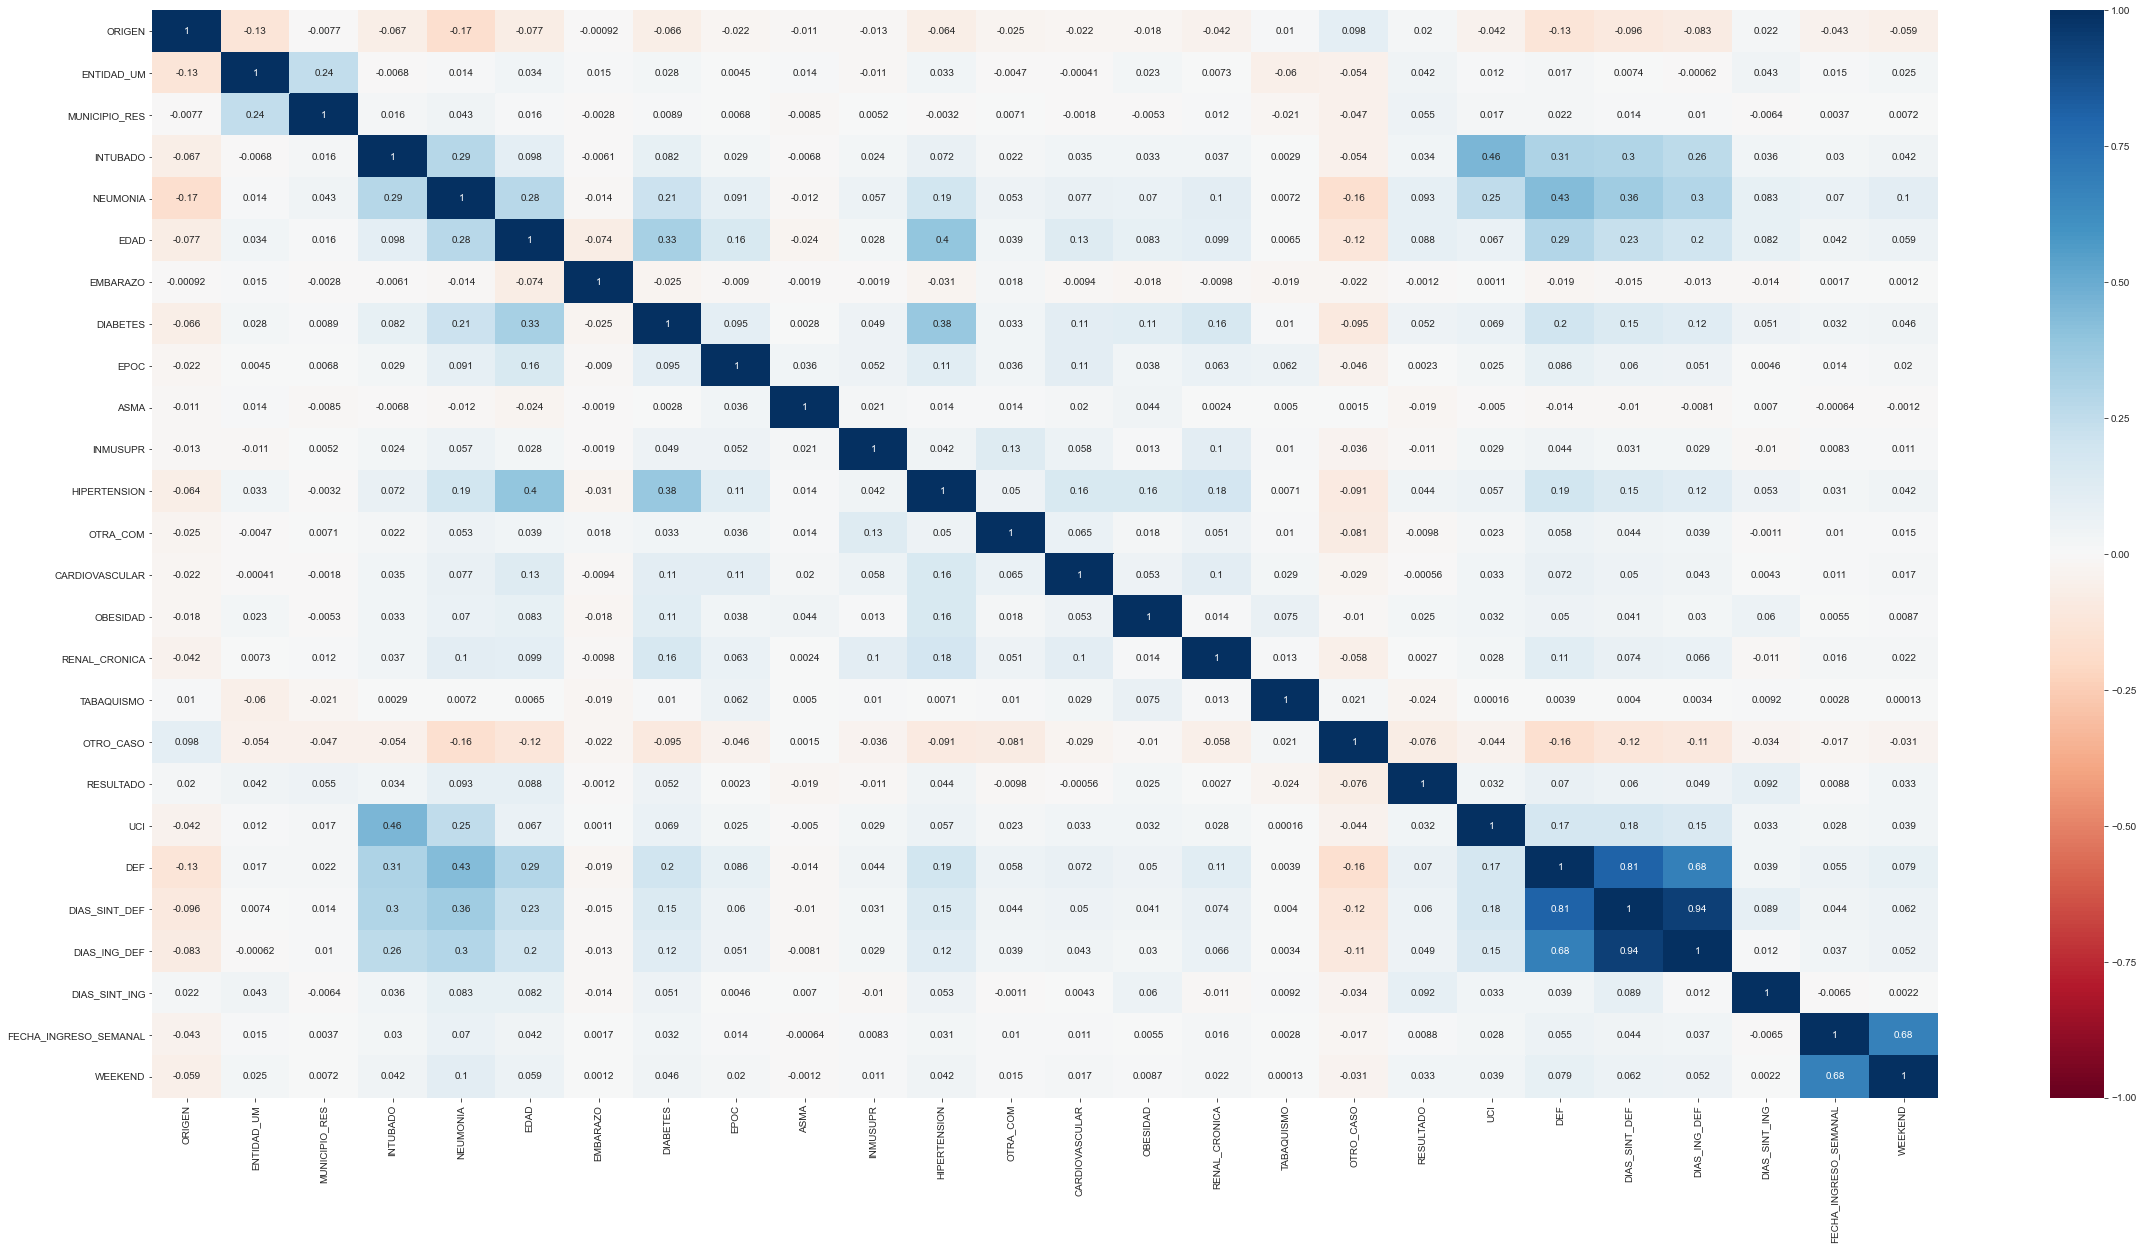

In [38]:
correlation = df_general.corr()
plt.figure(figsize=(40, 20))
sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu")

In [39]:
df_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112114 entries, 0 to 1112113
Data columns (total 37 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   FECHA_ACTUALIZACION    1112114 non-null  object        
 1   ID_REGISTRO            1112114 non-null  object        
 2   ORIGEN                 1112114 non-null  int64         
 3   SECTOR                 1112114 non-null  object        
 4   ENTIDAD_UM             1112114 non-null  int64         
 5   SEXO                   1112114 non-null  object        
 6   MUNICIPIO_RES          1112114 non-null  int64         
 7   TIPO_PACIENTE          1112114 non-null  object        
 8   FECHA_INGRESO          1112114 non-null  datetime64[ns]
 9   FECHA_SINTOMAS         1112114 non-null  datetime64[ns]
 10  FECHA_DEF              69207 non-null    datetime64[ns]
 11  INTUBADO               1112114 non-null  int64         
 12  NEUMONIA               11121

In [40]:
#df_clea_data = df_general.to_csv(path + 'clean_data.csv',index=False)

## Exploratory Data Analysis 

### States with more COVID-19 tests



The figure below shows percentage of COVID-19 tests done in Mexico broken by state. Mexico city is the federal entity with the most number of tests. In second place is Mexico (the state). 

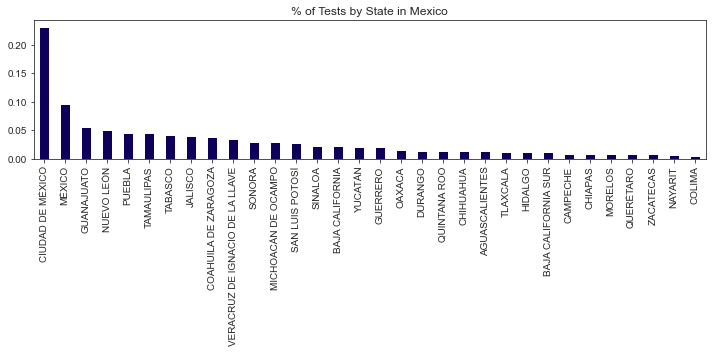

In [121]:
#plt.style.use('classic')
title_chart = '% of Tests by State in Mexico'
states_vals = df_general.ENTIDAD_NAME.value_counts()
#sns.set(palette="Blues_d")
sns.set_style("ticks")
fig = plt.figure(figsize=(10,5))
(states_vals/df_general.shape[0]).plot(kind="bar", color = '#0c005a');
plt.title(title_chart, fontsize = 12);
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [42]:
states_vals.sum()/ df_gender_pop.Total.sum() * 100

0.8625535204386741

In [43]:
df_states_by_result = df_general.copy()
indexPendintResult = df_states_by_result[ df_states_by_result['RESULTADO'] == 3 ].index
df_states_by_result.drop(indexPendintResult , inplace=True)
df_states_by_result['RESULTADO'].replace(to_replace=[1,0], value=['POSITIVO','NO POSITIVO'],inplace=True)

In [44]:
pd.crosstab(df_states_by_result.FECHA_ACTUALIZACION, df_states_by_result.RESULTADO)

RESULTADO,NO POSITIVO,POSITIVO
FECHA_ACTUALIZACION,,
2020-08-11,538333,492522


In [45]:
df_state_results = pd.crosstab(df_states_by_result.ENTIDAD, df_states_by_result.RESULTADO, normalize=True)

In [46]:
df_state_results = df_state_results.reset_index()

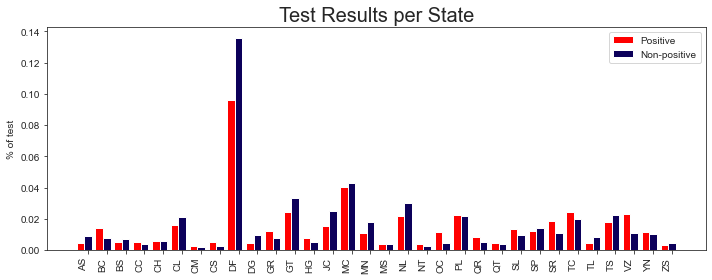

In [47]:
title_chart = 'Test Results per State'
width = 0.40
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(10, 4))


rects1 = ax.bar(x - width/2, df_state_results.POSITIVO, width, label='Positive', color = '#ff0000')
rects2 = ax.bar(x + width/2, df_state_results['NO POSITIVO'], width, label='Non-positive', color = '#0c005a')

ax.set_ylabel('% of test')
ax.set_title(title_chart, fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_state_results.ENTIDAD, rotation=90, ha='right')
ax.legend()
fig.tight_layout()



plt.savefig('images/' + title_chart + '.png')
plt.show()

The graph shows the results of the tests done by federal entity. The results in the graphs have been normalized.

## Values  per Capita

In [48]:
df_states_key_vals = df_general.ENTIDAD_UM.value_counts().to_frame()
df_states_key_vals = df_states_key_vals.reset_index()
df_states_key_vals.rename(columns={df_states_key_vals.columns[0]: 'abbr' ,
                                   'ENTIDAD_UM':  'TESTS'}, inplace = True)

In [49]:
df_population = pd.merge(df_population, df_states_key_vals, left_on='Num', right_on='abbr')

In [50]:
df_population['PER_CAPITA'] = df_population['TESTS'] / df_population['Total'] * 100000

In [51]:
df_population['TESTS'].sum() / df_population['Total'].sum() * 100000

989.984220450162

In [52]:
df_population['abbr'] = df_population['abbr'].map(df_states.set_index('CLAVE_ENTIDAD')['ABREVIATURA'])

In [53]:
df_population.sort_values('Total', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA
14,15,México,15175862.0,7396986.0,7778876.0,MC,105995,698.444675
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,256747,2900.742056
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37837,495.041733
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,44596,606.692005
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,50177,868.139871
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,60966,1111.226144
6,7,Chiapas,4796580.0,2352807.0,2443773.0,CS,8947,186.528735
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,56142,1206.457649
15,16,Michoacán de Ocampo,4351037.0,2102109.0,2248928.0,MN,31856,732.147302
19,20,Oaxaca,3801962.0,1819008.0,1982954.0,OC,17336,455.975099


In [54]:
df_population.sort_values('PER_CAPITA', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,256747,2900.742056
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13325,2091.751357
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,46478,2076.205562
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,41546,1511.648088
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48950,1497.604139
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32902,1235.765151
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,56142,1206.457649
23,24,San Luis Potosí,2585518.0,1260366.0,1325152.0,SP,30845,1192.991114
0,1,Aguascalientes,1184996.0,576638.0,608358.0,AS,14089,1188.949161
30,31,Yucatán,1955577.0,963333.0,992244.0,YN,23179,1185.276775


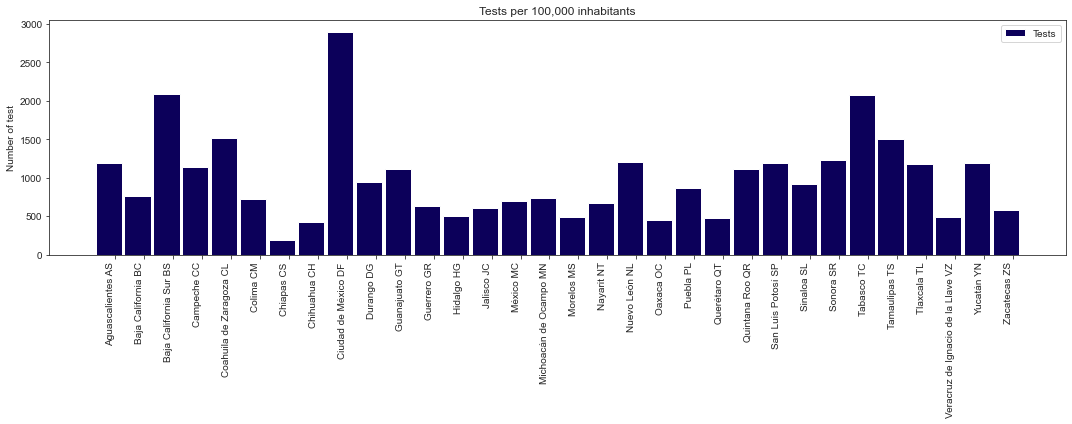

In [122]:
title_chart = 'Tests per 100,000 inhabitants'
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_population['PER_CAPITA'], width, label='Tests', color = '#0c005a')
ax.set_ylabel('Number of test')
ax.set_title(title_chart, fontsize = 12)
ax.set_xticks(x + width/4 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()

fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

### Positive cases per 100,000 inhabitants

In [56]:
df_result_tests = df_states_by_result.groupby(['ENTIDAD_UM', 'RESULTADO']).size().unstack()

In [57]:
df_result_tests = df_result_tests.reset_index()

In [58]:
df_population = pd.merge(df_population, df_result_tests, left_on='Num', right_on='ENTIDAD_UM')

In [59]:
# positive cases per capita
df_population['POS_PER_CAPITA'] = df_population['POSITIVO'] / df_population['Total'] * 100000

In [60]:
df_population.sort_values('POS_PER_CAPITA', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,256747,2900.742056,9,139931,98758,1115.773442
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,46478,2076.205562,27,20706,24940,1114.087670
2,3,Baja California Sur,637026.0,325433.0,311593.0,BS,13325,2091.751357,3,7251,5676,891.015437
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32902,1235.765151,26,11254,19483,731.761365
22,23,Quintana Roo,1325578.0,673220.0,652358.0,QR,14781,1115.060751,23,5293,8747,659.863094
3,4,Campeche,822441.0,407721.0,414720.0,CC,9361,1138.197147,4,4026,5138,624.725664
30,31,Yucatán,1955577.0,963333.0,992244.0,YN,23179,1185.276775,31,10884,11966,611.891017
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,41546,1511.648088,5,21882,16383,596.094224
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48950,1497.604139,28,23516,18696,571.996057
24,25,Sinaloa,2767761.0,1376201.0,1391560.0,SL,25362,916.336346,25,9983,14114,509.942874


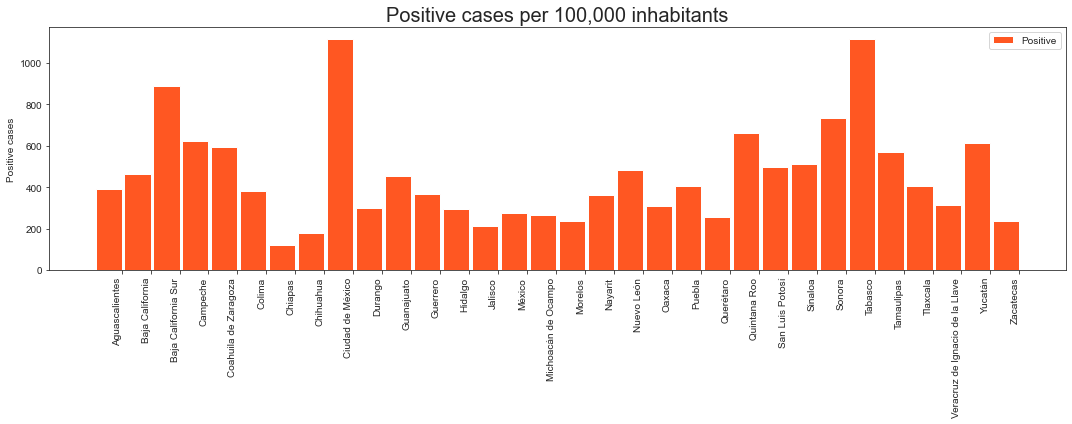

In [61]:
title_chart = 'Positive cases per 100,000 inhabitants'
width = 0.9 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff5722')

ax.set_ylabel('Positive cases')
ax.set_title(title_chart, fontsize = 20)
ax.set_xticks(x + width/2 )
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

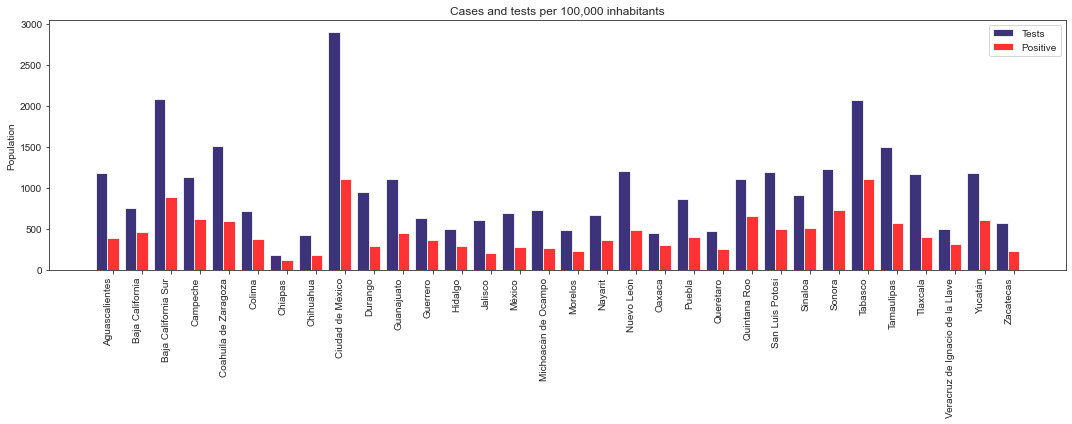

In [62]:
width = 0.4
title_chart = 'Cases and tests per 100,000 inhabitants' 
x = np.arange(len(df_population.Entidad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x - width/2, df_population['PER_CAPITA'], width, label='Tests', color = '#0c005a', alpha=0.8)
ax.bar(x + width/2, df_population['POS_PER_CAPITA'], width, label='Positive', color = '#ff0000', alpha=0.8)


ax.set_ylabel('Population')
ax.set_title(title_chart, fontsize = 12)
ax.set_xticks(x + width/2)
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.savefig( 'images/' + title_chart + '.png')

plt.show()

In [63]:
df_population.sort_values('Total', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA
14,15,México,15175862.0,7396986.0,7778876.0,MC,105995,698.444675,15,44580,41992,276.702569
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,256747,2900.742056,9,139931,98758,1115.773442
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37837,495.041733,30,11442,24054,314.711363
13,14,Jalisco,7350682.0,3600641.0,3750041.0,JC,44596,606.692005,14,25911,15698,213.558415
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,50177,868.139871,21,22362,23361,404.181508
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,60966,1111.226144,11,34354,24958,454.909000
6,7,Chiapas,4796580.0,2352807.0,2443773.0,CS,8947,186.528735,7,3024,5717,119.189089
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,56142,1206.457649,19,31258,22536,484.285020
15,16,Michoacán de Ocampo,4351037.0,2102109.0,2248928.0,MN,31856,732.147302,16,18452,11556,265.591858
19,20,Oaxaca,3801962.0,1819008.0,1982954.0,OC,17336,455.975099,20,4898,11691,307.499128


In [64]:
# positve cases normalized
df_population['POS_NOR'] = df_population.POSITIVO/ df_population.POSITIVO.sum()

In [65]:
df_population.sort_values('POS_NOR', ascending=False)

,Num,Entidad,Total,Hombres,Mujeres,abbr,TESTS,PER_CAPITA,ENTIDAD_UM,NO POSITIVO,POSITIVO,POS_PER_CAPITA,POS_NOR
8,9,Ciudad de México,8851080.0,4233783.0,4617297.0,DF,256747,2900.742056,9,139931,98758,1115.773442,0.200515
14,15,México,15175862.0,7396986.0,7778876.0,MC,105995,698.444675,15,44580,41992,276.702569,0.085259
10,11,Guanajuato,5486372.0,2639425.0,2846947.0,GT,60966,1111.226144,11,34354,24958,454.909000,0.050674
26,27,Tabasco,2238603.0,1100758.0,1137845.0,TC,46478,2076.205562,27,20706,24940,1114.087670,0.050637
29,30,Veracruz de Ignacio de la Llave,7643194.0,3695679.0,3947515.0,VZ,37837,495.041733,30,11442,24054,314.711363,0.048838
20,21,Puebla,5779829.0,2769855.0,3009974.0,PL,50177,868.139871,21,22362,23361,404.181508,0.047431
18,19,Nuevo León,4653458.0,2320185.0,2333273.0,NL,56142,1206.457649,19,31258,22536,484.285020,0.045756
25,26,Sonora,2662480.0,1339612.0,1322868.0,SR,32902,1235.765151,26,11254,19483,731.761365,0.039558
27,28,Tamaulipas,3268554.0,1616201.0,1652353.0,TS,48950,1497.604139,28,23516,18696,571.996057,0.037960
4,5,Coahuila de Zaragoza,2748391.0,1364197.0,1384194.0,CL,41546,1511.648088,5,21882,16383,596.094224,0.033263


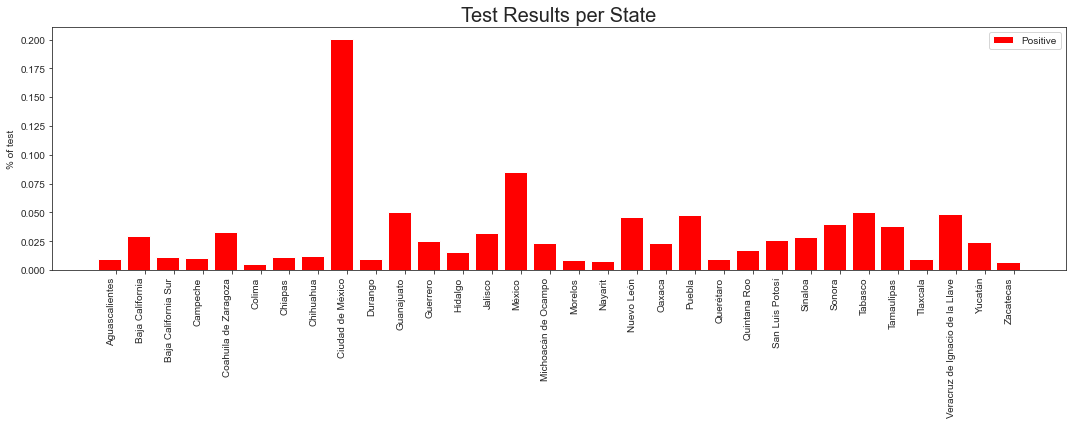

In [66]:
title_chart = 'Test Results per State'
width = 0.8
x = np.arange(len(df_state_results.ENTIDAD))
fig, ax = plt.subplots(figsize=(15, 6))

rects1 = ax.bar(x, df_population.POS_NOR, width, label='Positive', color = '#ff0000')

ax.set_ylabel('% of test')
ax.set_title(title_chart, fontsize = 20)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_population.Entidad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

In [67]:
df_population['Entidad'] = df_population[['Entidad', 'abbr']].agg(' '.join, axis=1)

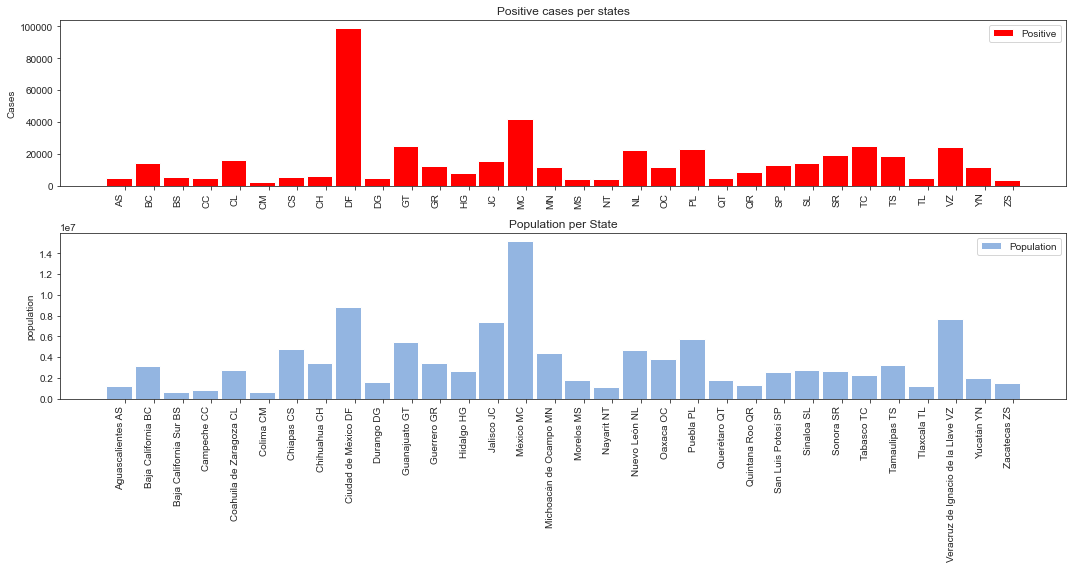

In [68]:
title_chart = 'Population and Positive cases per state'
width = 0.9 
fig, axs =plt.subplots(2,1, figsize=(15, 8))

axs[0].bar(x, df_population.POSITIVO, width, label='Positive', color = '#ff0000')

axs[0].set_title('Positive cases per states')
axs[0].set_ylabel('Cases')
axs[0].set_xticks(x + width/4)
axs[0].set_xticklabels(df_population.abbr, rotation=90, ha='right')
axs[0].legend()

axs[1].bar(x, df_population.Total, width, label='Population', color = '#93b5e1')
axs[1].set_title('Population per State')
axs[1].set_ylabel('population')
axs[1].set_xticks(x + width/4)
axs[1].set_xticklabels(df_population.Entidad, rotation=90, ha='right')
axs[1].legend()

#fig.suptitle(title_chart, fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)
fig.tight_layout()
plt.savefig('images/' + title_chart + '.png')

###  Summary of Confimed/Deaths

In [69]:
df_positive = df_general[ df_general['RESULTADO'] == 1]
df_positive = df_positive[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD']]

In [70]:
df_positive.rename({'EDAD': "Age"}, axis=1, inplace=True)

In [71]:
df_positive.DEF.sum()

53929

In [72]:
def bar_char (x_val, y_val, color_num, title_chart, y_axis_name, x_axis_name, i = False, figsize=(15,4) ):
    fig, ax = plt.subplots(figsize= figsize)
    x_pos = np.arange(len(x_val))

    ax.bar(x_pos, y_val, color=color_num)
    ax.set_ylabel(y_axis_name)
    ax.set_xlabel(x_axis_name)
    ax.set_title(title_chart, fontsize = 12)
    
    if i:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(x_val, rotation=90, ha='right')
        ax.legend()
        
    plt.tight_layout()
    plt.savefig( 'images/' + title_chart + '.png')
    plt.show()
    


In [73]:
df_death_date = pd.crosstab(df_positive['FECHA_DEF'], df_positive.DEF)
df_death_date = df_death_date.reset_index()
df_death_date.rename({1: 'DEF'}, axis=1, inplace=True)

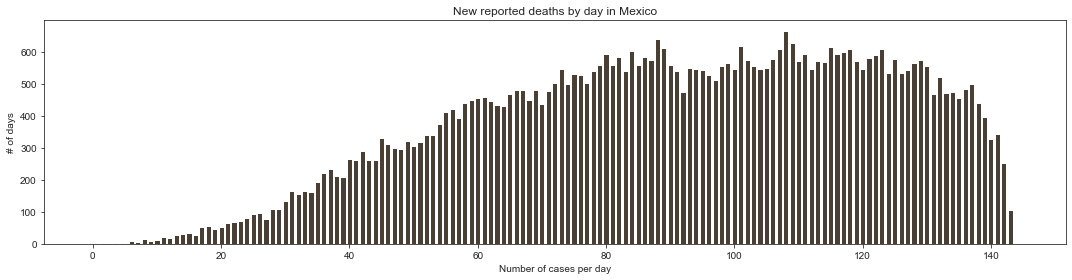

In [74]:
bar_char(df_death_date.FECHA_DEF, 
         df_death_date.DEF, 
         '#4a3f35', 
         'New reported deaths by day in Mexico', 
         '# of days',
         'Number of cases per day')

In [75]:
df_death_age = df_general[ df_general['DEF'] == 1]

In [76]:
df_death_age = df_death_age[['FECHA_ACTUALIZACION','FECHA_INGRESO', 'FECHA_DEF',
                           'RESULTADO', 'DEF', 'DIAS_SINT_ING', 'SEXO', 'EDAD']]

In [77]:
df_death_age

,FECHA_ACTUALIZACION,FECHA_INGRESO,FECHA_DEF,RESULTADO,DEF,DIAS_SINT_ING,SEXO,EDAD
11,2020-08-11,2020-05-20,2020-06-05,1,1,6,Men,43
22,2020-08-11,2020-04-08,2020-05-09,1,1,0,Men,57
24,2020-08-11,2020-03-30,2020-04-11,1,1,2,Women,70
30,2020-08-11,2020-05-15,2020-06-04,1,1,5,Men,66
31,2020-08-11,2020-06-08,2020-06-15,1,1,7,Men,34
...,...,...,...,...,...,...,...,...
1111810,2020-08-11,2020-07-17,2020-07-22,3,1,0,Women,38
1111859,2020-08-11,2020-08-07,2020-08-09,3,1,6,Men,88
1111895,2020-08-11,2020-07-11,2020-07-11,3,1,6,Men,77
1111897,2020-08-11,2020-07-12,2020-07-13,3,1,4,Women,46


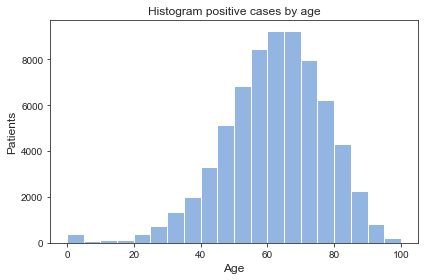

In [78]:
title_chart = 'Histogram positive cases by age'
fig= plt.figure(figsize=(6,4))

bins_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# create the histogram
(n, bins, patches) = plt.hist(df_death_age.EDAD, bins=bins_list,   label='hst', color = '#93b5e1')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Patients',  size=12)
plt.title(title_chart,  size=12)

#plt.grid(True)
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [79]:
death_age_list = n
death_age_list= np.insert(death_age_list, 20,0)

In [80]:
len(death_age_list)

21

In [81]:
df_gender_pop['Deaths_Covid'] = death_age_list

In [82]:
df_gender_pop['Ratio_Deaths_Covid'] = df_gender_pop.Deaths_Covid/df_gender_pop.Total

In [83]:
df_gender_pop

,Edad,M,F,Total,Deaths_Covid,Ratio_Deaths_Covid
0,0-4,5604781,5353961,10958742,398.0,0.000036
1,5-9,5731706,5478805,11210511,82.0,0.000007
2,10-14,5692822,5448048,11140870,105.0,0.000009
3,15-19,5695013,5514580,11209593,142.0,0.000013
4,20-24,5505161,5434658,10939819,368.0,0.000034
5,25-29,5384130,5411644,10795774,728.0,0.000067
6,30-34,4748412,5041468,9789880,1357.0,0.000139
7,35-39,4343789,4746361,9090150,1987.0,0.000219
8,40-44,4029738,4502226,8531964,3288.0,0.000385
9,45-49,3782769,4233025,8015794,5127.0,0.000640


No handles with labels found to put in legend.


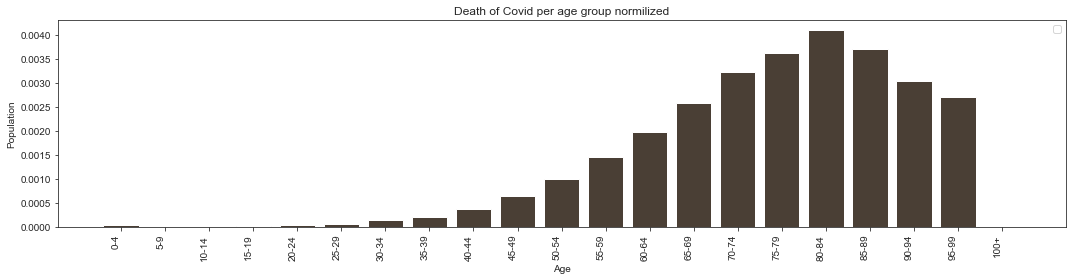

In [84]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Ratio_Deaths_Covid, 
         '#4a3f35', 
         'Death of Covid per age group normilized', 
         'Population',
         'Age',
          True)

In [85]:
df_dying  = df_general[(df_general['RESULTADO'] == 1 ) & (df_general['DEF'] == 1 )]
df_dying = df_dying[['FECHA_DEF','DIAS_SINT_DEF', 'FECHA_INGRESO_SEMANAL', 'SEXO']]
df_dying.set_index('FECHA_DEF', inplace=True)
df_dying.index = pd.to_datetime(df_dying.index)

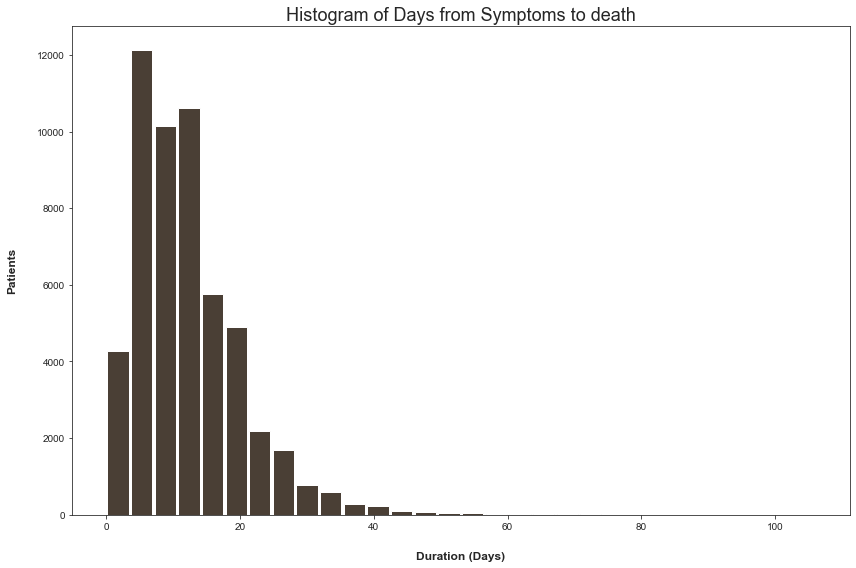

In [86]:
title_chart = 'Histogram of Days from Symptoms to death'
ax = df_dying.hist(column='DIAS_SINT_DEF', bins=30, grid=False, figsize=(12,8), color='#4a3f35',  rwidth=0.9)

for x in ax[0]:
    x.set_title(title_chart, fontsize = 18)
    x.set_xlabel('Duration (Days)', labelpad=20, weight='bold', size=12)
    x.set_ylabel('Patients', labelpad=20, weight='bold', size=12)

plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

In [87]:
outlier = df_dying[df_dying['DIAS_SINT_DEF']>30].count()
outlier

DIAS_SINT_DEF            1691
FECHA_INGRESO_SEMANAL    1691
SEXO                     1691
dtype: int64

The avergare number of days for a patient with COVID19 to dies is almost 12. There are cases that takes up to more than 3 months.


In [88]:
df_dying.describe()

,DIAS_SINT_DEF,FECHA_INGRESO_SEMANAL
count,53929.000000,53929.000000
mean,12.278106,2.860075
std,8.128377,1.989515
min,0.000000,0.000000
25%,7.000000,1.000000
50%,11.000000,3.000000
75%,16.000000,5.000000
max,106.000000,6.000000


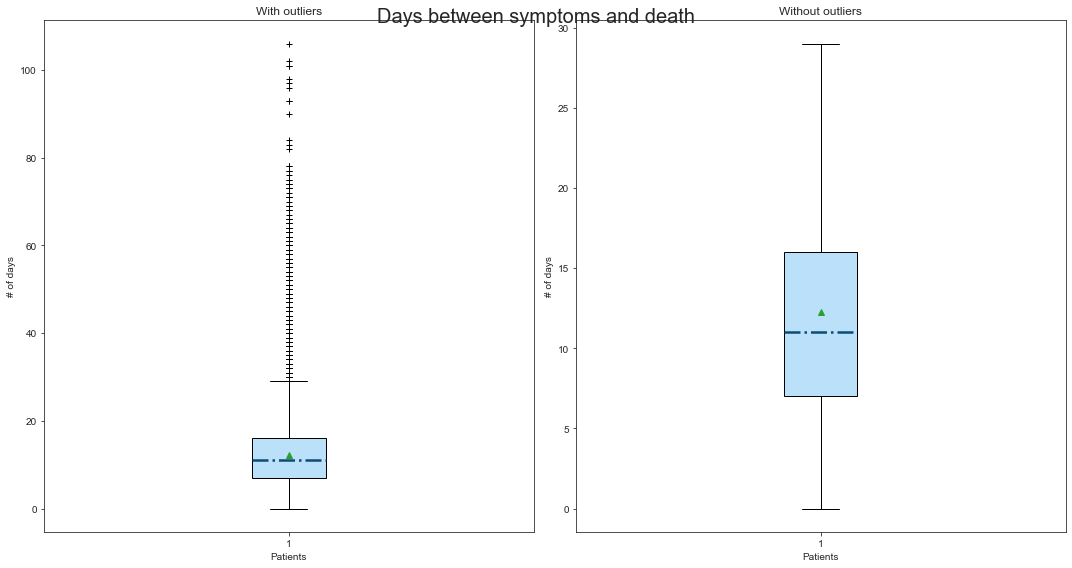

In [89]:
title_chart = 'Days between symptoms and death'
fig, axs =plt.subplots(1,2, figsize=(15, 8))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs[0].boxplot(df_dying['DIAS_SINT_DEF'],notch=0, sym='+', vert=1, whis=1.5,  patch_artist=True, 
               medianprops=medianprops, boxprops=dict(facecolor='#bbe1fa'),showmeans=True )
axs[0].set_title('With outliers')
axs[0].set_ylabel('# of days')
axs[0].set_xlabel('Patients')

axs[1].boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs[1].set_title("Without outliers")
axs[1].set_ylabel('# of days')
axs[1].set_xlabel('Patients')

fig.suptitle(title_chart, fontsize=12)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

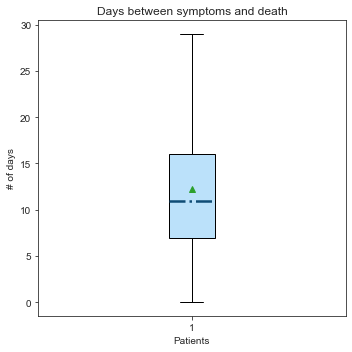

In [90]:
title_chart = 'Days between symptoms and death'
fig, axs =plt.subplots(figsize=(5,5))
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')
medianprops = dict(linestyle='-.', linewidth=2.5, color='#0f4c75')

axs.boxplot(df_dying['DIAS_SINT_DEF'], 0, '', patch_artist=True, 
               boxprops=dict(facecolor='#bbe1fa'), showmeans=True, medianprops=medianprops)
axs.set_title(title_chart)
axs.set_ylabel('# of days')
axs.set_xlabel('Patients')

#fig.suptitle(title_chart, fontsize=20)
fig.subplots_adjust(left=0.09, right=0.9, bottom=0.05, top=0.8,
                    hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')

The boxplots show the distribution between number of days from first symptoms to death. The first boxplot includes outlier. In the second boxplot the outliers are removed.

### Confirmed Positive COVID-19 cases

In [91]:
df_gender_pop = df_gender_pop.dropna()


In [92]:
df_gender_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Edad                21 non-null     object 
 1   M                   21 non-null     int64  
 2   F                   21 non-null     int64  
 3   Total               21 non-null     int64  
 4   Deaths_Covid        21 non-null     float64
 5   Ratio_Deaths_Covid  21 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.1+ KB


In [93]:
gender_vals = list(df_positive.SEXO.value_counts(normalize=True))

In [94]:
gender_vals

[0.5289428695570959, 0.4710571304429041]

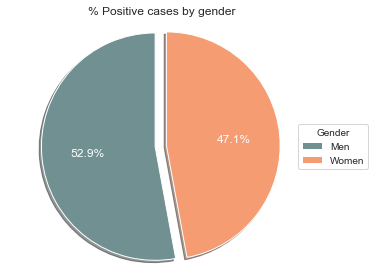

In [95]:
title_chart = '% Positive cases by gender'
labels ='Men', 'Women',
sizes = gender_vals
cs = ['#719092', '#F59C72']
#cs = ['#02383c', '#ed5107']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(5, 4))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 12, 'color':"w"})

ax.set_title(title_chart, fontsize = 12)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [96]:
# Percentage population by gender
pop_gender_nor_list = list()
pop_gender_nor_list.append(df_gender_pop.M.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list.append(df_gender_pop.F.sum()/df_gender_pop.Total.sum())
pop_gender_nor_list

[0.48918125559608583, 0.5108187444039142]

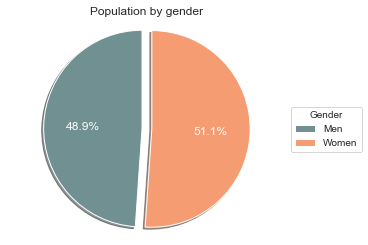

In [97]:
title_chart = 'Population by gender'
labels ='Men', 'Women',
sizes = pop_gender_nor_list
cs = ['#719092', '#F59C72']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig, ax = plt.subplots(figsize=(5, 4))

wedges, texts, autotexts =  ax.pie(sizes, colors= cs, explode=explode, labels=labels, autopct='%1.1f%%',
                                   shadow=True, startangle=90, textprops={'fontsize': 12, 'color':"w"})

ax.set_title(title_chart, fontsize = 12)
ax.legend(wedges, labels,
          title="Gender",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig('images/' + title_chart + '.png')
plt.show()

In [98]:
pop_gender_list = list()
pop_gender_list.append(df_gender_pop.M.sum())
pop_gender_list.append(df_gender_pop.F.sum())

In [99]:
gender_values = list(df_positive.SEXO.value_counts())
gender = ['men','women']

In [100]:
dict = {'gender': gender, 'Covid': gender_values, 'Population': pop_gender_list}  
    
df_total_gender = pd.DataFrame(dict) 

In [101]:
df_total_gender['Ratio_Covid_Total'] = df_total_gender.Covid/df_total_gender.Population
df_total_gender

,gender,Covid,Population,Ratio_Covid_Total
0,men,260516,63071486,0.004130
1,women,232006,65861267,0.003523


No handles with labels found to put in legend.


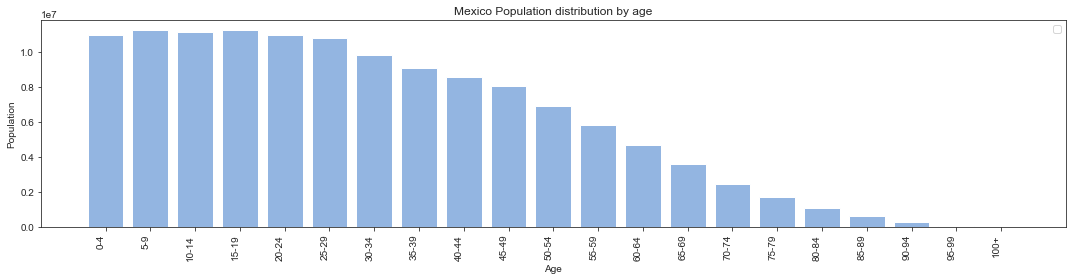

In [102]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Total,
         '#93b5e1', 
         'Mexico Population distribution by age', 
         'Population',
         'Age',
          True)

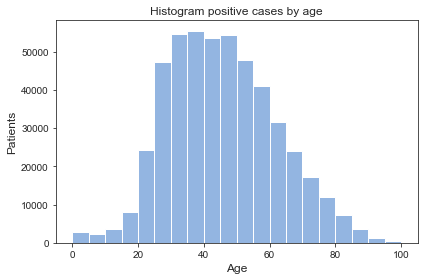

In [103]:
title_chart = 'Histogram positive cases by age'
fig= plt.figure(figsize=(6,4))

bins_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

# create the histogram
(n, bins, patches) = plt.hist(df_positive.Age, bins=bins_list,   label='hst', color = '#93b5e1')
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Patients',  size=12)
plt.title(title_chart,  size=12)


plt.tight_layout()
plt.savefig('images/' + title_chart + '.png')
plt.show()

In [104]:
covid_age_list = n

In [105]:
# Add the last element to match the size of dataframe gender population
covid_age_list= np.insert(covid_age_list, 20,0)

In [106]:
len(covid_age_list) 

21

In [107]:
df_gender_pop['Cases_Covid'] = covid_age_list

In [108]:
df_gender_pop['Ratio_Covid_Total'] = df_gender_pop.Cases_Covid/df_gender_pop.Total

In [109]:
df_gender_pop

,Edad,M,F,Total,Deaths_Covid,Ratio_Deaths_Covid,Cases_Covid,Ratio_Covid_Total
0,0-4,5604781,5353961,10958742,398.0,0.000036,2885.0,0.000263
1,5-9,5731706,5478805,11210511,82.0,0.000007,2228.0,0.000199
2,10-14,5692822,5448048,11140870,105.0,0.000009,3679.0,0.000330
3,15-19,5695013,5514580,11209593,142.0,0.000013,8184.0,0.000730
4,20-24,5505161,5434658,10939819,368.0,0.000034,24178.0,0.002210
5,25-29,5384130,5411644,10795774,728.0,0.000067,47406.0,0.004391
6,30-34,4748412,5041468,9789880,1357.0,0.000139,54617.0,0.005579
7,35-39,4343789,4746361,9090150,1987.0,0.000219,55398.0,0.006094
8,40-44,4029738,4502226,8531964,3288.0,0.000385,53465.0,0.006266
9,45-49,3782769,4233025,8015794,5127.0,0.000640,54397.0,0.006786


No handles with labels found to put in legend.


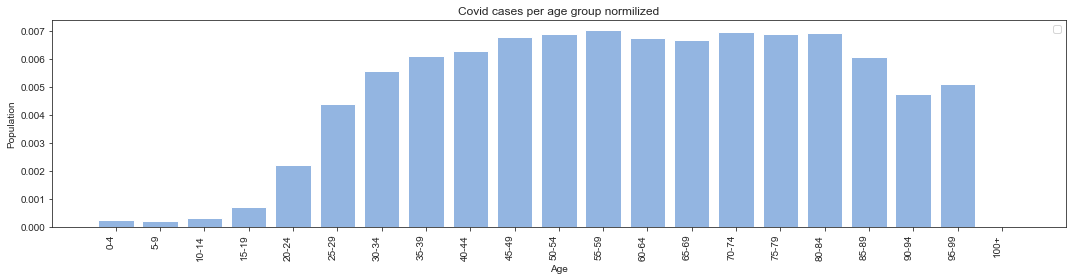

In [110]:
bar_char(df_gender_pop.Edad, 
         df_gender_pop.Ratio_Covid_Total,
         '#93b5e1', 
         'Covid cases per age group normilized', 
         'Population',
         'Age',
          True)

In [111]:
df_age_women = df_positive[df_positive.SEXO == 'Women']
df_age_men = df_positive[df_positive.SEXO == 'Men']
age_women = list(df_age_women['Age'])
age_men = list(df_age_men['Age'])

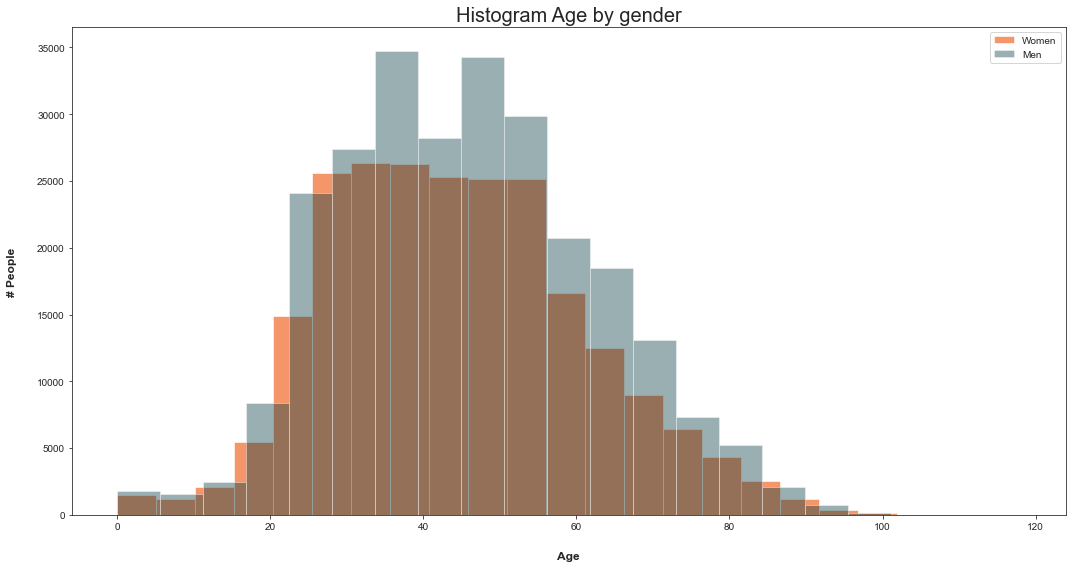

In [112]:
title_chart = 'Histogram Age by gender'
fig, ax =plt.subplots(figsize=(15, 8))

bins = 21 
ax.hist(age_women, bins, alpha=0.6, label='Women', color='#ed5107' )
ax.hist(age_men, bins, alpha=0.4, label='Men', color='#02383c')
ax.legend()
ax.set_title(title_chart, fontsize = 20)
ax.set_xlabel("Age", labelpad=20, weight='bold', size=12)
ax.set_ylabel("# People", labelpad=20, weight='bold', size=12)
fig.tight_layout()

plt.savefig('images/' + title_chart + '.png')
plt.show()

Histogram of age broken by gender. 

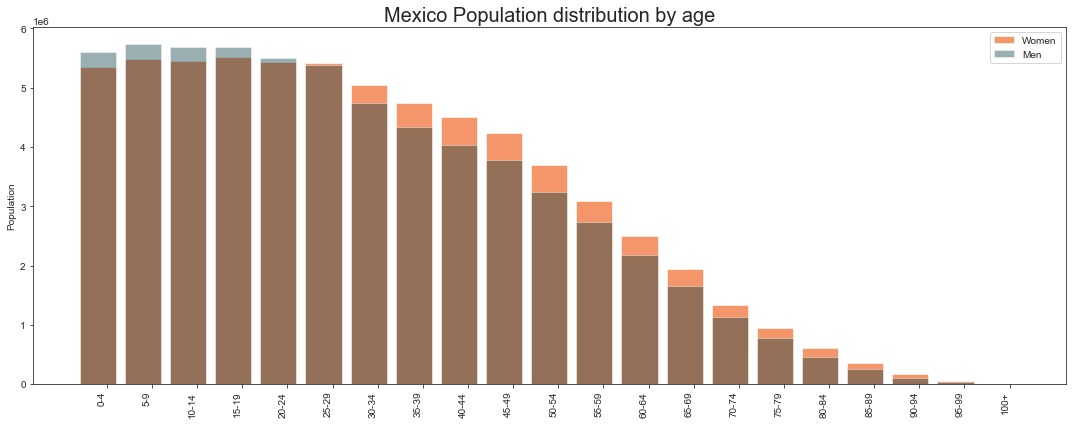

In [113]:
width = 0.8
title_chart = 'Mexico Population distribution by age' 
x = np.arange(len(df_gender_pop.Edad))
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(x, df_gender_pop.F, width, label='Women', color = '#ed5107', alpha=0.6)
ax.bar(x, df_gender_pop.M, width, label='Men', color = '#02383c', alpha=0.4)

ax.set_ylabel('Population')
ax.set_title(title_chart, fontsize = 20)
ax.set_xticks(x + width/4)
ax.set_xticklabels(df_gender_pop.Edad, rotation=90, ha='right')
ax.legend()
fig.tight_layout()

plt.savefig( 'images/' + title_chart + '.png')

plt.show()

In [114]:
df_hosp = df_positive[['FECHA_INGRESO', 'DIAS_SINT_ING']]
print ('Average number of days between first symptoms to hospitalization : ' + str(df_hosp.DIAS_SINT_ING.mean()))

Average number of days between first symptoms to hospitalization : 4.299761228940027


In [115]:
df_positive_results = pd.crosstab(df_positive['FECHA_INGRESO'], df_positive.RESULTADO)
df_positive_results = df_positive_results.reset_index()
df_positive_results.rename({1: 'POSITIVO'}, axis=1, inplace=True)

In [116]:
df_positive_results.POSITIVO.sum()

492522

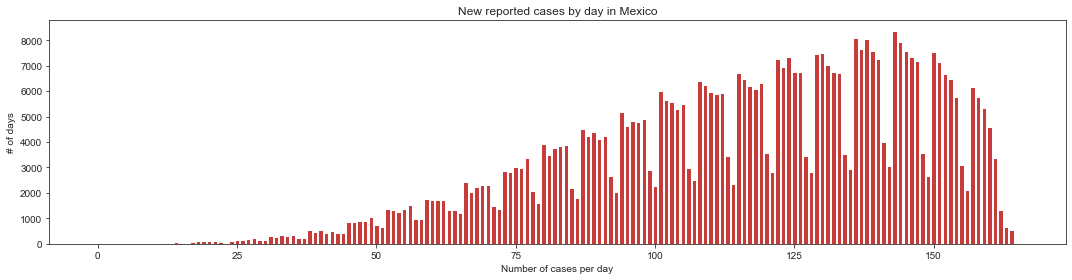

In [117]:
bar_char(df_positive_results.FECHA_INGRESO, 
         df_positive_results.POSITIVO,
         '#c83b3b', 
         'New reported cases by day in Mexico',
         '# of days',
         'Number of cases per day' )

The graph show a sharp decline every 6th and 7th day.